<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [29]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

import scipy.stats as stats
import statsmodels.stats.api as sms

import pylab as plt
import seaborn as sns

%matplotlib inline

In [3]:
# datos
df=pd.read_csv(r'C:\Users\Oriana Ampuero\ironhack\semana6\6.4_lab-AB-Testing\data/cookie_cats.csv')

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [8]:
df.shape

(90189, 5)

In [5]:
df.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [6]:
df.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [ ]:
# testeo para retention_1

In [17]:
pd.crosstab(df.version, df.retention_1)

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


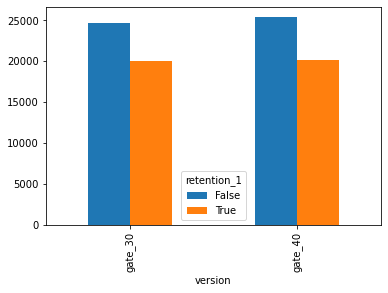

In [19]:
pd.crosstab(df.version, df.retention_1).plot(kind='bar');

In [21]:
cont= df[df.version=='gate_30'].sample(n=44700, random_state=45)

trat= df[df.version=='gate_40'].sample(n=44700, random_state=45)

ab_test=pd.concat([cont, trat], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,5904325,gate_30,1,False,False
1,7223810,gate_30,38,True,False
2,3156716,gate_30,481,True,True
3,9768250,gate_30,60,False,False
4,106487,gate_30,11,False,False


In [22]:
ab_test.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
89395,4918784,gate_40,2,True,False
89396,1715389,gate_40,36,True,True
89397,4294046,gate_40,1,False,False
89398,4786797,gate_40,8,False,False
89399,6394719,gate_40,36,True,False


In [23]:
ab_test.version.value_counts()

gate_30    44700
gate_40    44700
Name: version, dtype: int64

In [27]:
tasa_conver=ab_test.groupby('version')['retention_1']  

std=lambda x: np.std(x, ddof=0)   

error_std=lambda x: stats.sem(x, ddof=0)  

tasa_conver=tasa_conver.agg([np.mean, std, error_std])
tasa_conver.columns=['conversion_rate', 'std', 'std_error']


tasa_conver.style.format('{:.3f}')

,conversion_rate,std,std_error
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.443,0.497,0.002


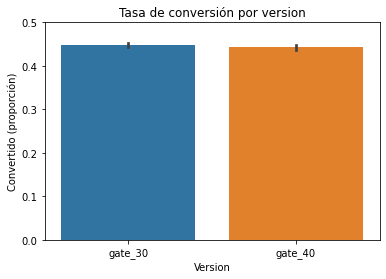

In [33]:
plt.figure(figsize=(6,4))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_1'])

plt.ylim(0, 0.50)
plt.title('Tasa de conversión por version')
plt.xlabel('Version')
plt.ylabel('Convertido (proporción)');

In [40]:
cont_res=ab_test[ab_test.version=='gate_30']['retention_1']

trat_res=ab_test[ab_test.version=='gate_40']['retention_1']


In [ ]:
observaciones_1=[20034, 20034] 

conversiones_1=[control_res_1.sum(), tratamiento_res_1.sum()]   # conversiones por grupo

print(conversiones_1)
z_score, p_valor = proportions_ztest(conversiones_1, nobs=observaciones_1)  # diferencia significativa
print(z_score)


In [ ]:
(control_a, tratamiento_a), (control_b, tratamiento_b)  = proportion_confint(conversiones_1,  nobs=observaciones_1, alpha=0.05)

In [5]:
# testeo para retention_7

In [18]:
pd.crosstab(df.version, df.retention_7)

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


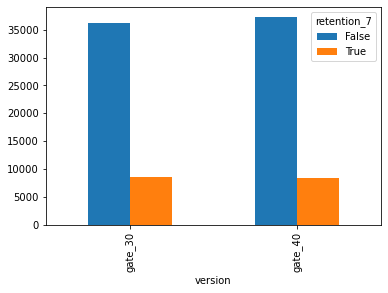

In [20]:
pd.crosstab(df.version, df.retention_7).plot(kind='bar');

In [41]:
cont= df[df.version=='gate_30'].sample(n=44700, random_state=45)

trat= df[df.version=='gate_40'].sample(n=44700, random_state=45)

ab_test=pd.concat([cont, trat], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,5904325,gate_30,1,False,False
1,7223810,gate_30,38,True,False
2,3156716,gate_30,481,True,True
3,9768250,gate_30,60,False,False
4,106487,gate_30,11,False,False


In [42]:
tasa_conver=ab_test.groupby('version')['retention_7']  

std=lambda x: np.std(x, ddof=0)   

error_std=lambda x: stats.sem(x, ddof=0)  

tasa_conver=tasa_conver.agg([np.mean, std, error_std])
tasa_conver.columns=['conversion_rate', 'std', 'std_error']


tasa_conver.style.format('{:.3f}')

,conversion_rate,std,std_error
version,,,
gate_30,0.190,0.392,0.002
gate_40,0.182,0.386,0.002


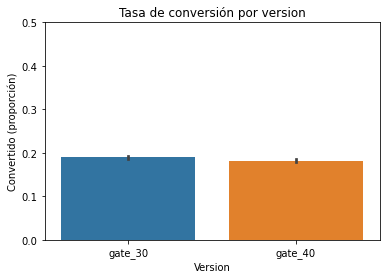

In [43]:
plt.figure(figsize=(6,4))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_7'])

plt.ylim(0, 0.50)
plt.title('Tasa de conversión por version')
plt.xlabel('Version')
plt.ylabel('Convertido (proporción)');

In [ ]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.